In [1]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
# SQL server connect
import sqlite3
# Plot data
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
# Transfomer catergorical data
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Split train test randomly
from sklearn.model_selection import train_test_split
# Build data pipieline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

# Import & EDA

In [2]:
# Import data and start EDA
df = pd.read_csv("csv_files/csv_building_structure.csv").set_index("building_id")
df.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,1,9,288,9,9,Flat,...,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
120101000021,12,1207,120703,1,1,15,364,9,9,Flat,...,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
120101000031,12,1207,120703,1,1,20,384,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
120101000041,12,1207,120703,1,1,20,312,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
120101000051,12,1207,120703,1,1,30,308,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair


`damage_grade` is an importance feature to determine the damage of the building. I will clear null data in `damage_grade` column and process

In [3]:
# Find number of null values in damage grade
df["damage_grade"].isnull().sum()

12

In [4]:
# Drop nulls values
df.dropna(subset=["damage_grade"],inplace=True)
df["damage_grade"].isnull().sum()

0

Change `damage_grade` into binary cassification feature `severe_damage`

In [5]:
# Use damage_grade to create classification feature
df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
df["severe_damage"] = (df["damage_grade"]>3).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762094 entries, 120101000011 to 366709001281
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   district_id                             762094 non-null  int64 
 1   vdcmun_id                               762094 non-null  int64 
 2   ward_id                                 762094 non-null  int64 
 3   count_floors_pre_eq                     762094 non-null  int64 
 4   count_floors_post_eq                    762094 non-null  int64 
 5   age_building                            762094 non-null  int64 
 6   plinth_area_sq_ft                       762094 non-null  int64 
 7   height_ft_pre_eq                        762094 non-null  int64 
 8   height_ft_post_eq                       762094 non-null  int64 
 9   land_surface_condition                  762094 non-null  object
 10  foundation_type                        

In [6]:
# Drop old column
df.drop(columns="damage_grade",inplace=True)

Find leakage in your data. These `post_eq` columns is a leakage and need to be drop

In [7]:
# Identify leakage in data is `post_eq` columns
drop_cols = [col for col in df.columns if "post_eq" in col]
# technical_solution_proposed is a leak as well
drop_cols.append("technical_solution_proposed")
# Drop all leak columns
df.drop(columns=drop_cols,inplace=True)

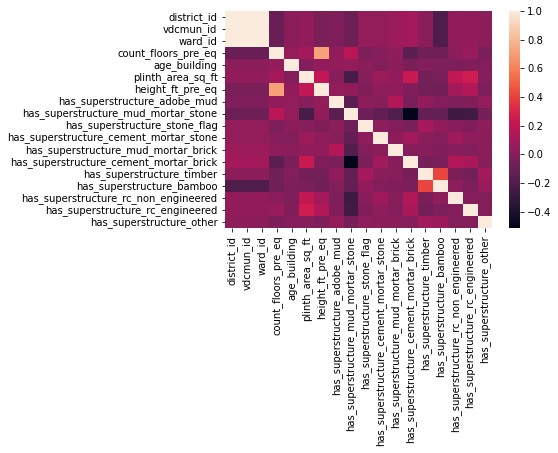

In [8]:
# Find high collinearity features
correlation = df.select_dtypes("number").drop(columns = "severe_damage").corr()
sns.heatmap(correlation);

In [9]:
h,f = df["severe_damage"].corr(df["height_ft_pre_eq"]), df["severe_damage"].corr(df["count_floors_pre_eq"])
h,f

(0.04911364038144871, 0.16904872399965754)

District vs vdcmun and ward are redundance information. `severe_damage` and `count_floors_pre_eq` are multicolinearity features. Using correlation with `severe_damage`, drop `height_ft_pre_eq`

In [10]:
df.drop(columns=["height_ft_pre_eq","district_id","vdcmun_id","ward_id"], inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762094 entries, 120101000011 to 366709001281
Data columns (total 22 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   count_floors_pre_eq                     762094 non-null  int64 
 1   age_building                            762094 non-null  int64 
 2   plinth_area_sq_ft                       762094 non-null  int64 
 3   land_surface_condition                  762094 non-null  object
 4   foundation_type                         762094 non-null  object
 5   roof_type                               762094 non-null  object
 6   ground_floor_type                       762094 non-null  object
 7   other_floor_type                        762094 non-null  object
 8   position                                762094 non-null  object
 9   plan_configuration                      762094 non-null  object
 10  has_superstructure_adobe_mud           

# Explore

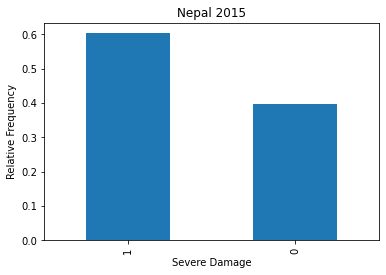

In [12]:
# Plot to check the class balance
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel = "Severe Damage",
    ylabel = "Relative Frequency",
    title = "Nepal 2015"
);

In [13]:
df["severe_damage"].value_counts(normalize=True)

1    0.603088
0    0.396912
Name: severe_damage, dtype: float64

# Split

In [14]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (762094, 21)
y shape: (762094,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (609675, 21)
y_train shape: (609675,)
X_test shape: (152419, 21)
y_test shape: (152419,)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (487740, 21)
y_train shape: (487740,)
X_val shape: (121935, 21)
y_val shape: (121935,)


# Build model

## Create baseline model

In [17]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.6


In [18]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
model_lr.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Evaluate Logistic Regression model

In [19]:
lr_train_acc = model_lr.score(X_train,y_train)
lr_val_acc = model_lr.score(X_val,y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.7319145446344364
Logistic Regression, Validation Accuracy Score: 0.7299216795833846


Using Decision Tree to find if we can improve accuracy score

In [20]:
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d ,random_state=42)
    )
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train, y_train))
    validation_acc.append(model_dt.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.714843974248575, 0.729556731045229, 0.7300775003075409]
Validation Accuracy Scores: [0.7138557428137943, 0.727715586172961, 0.7281666461639398]


Plot the result

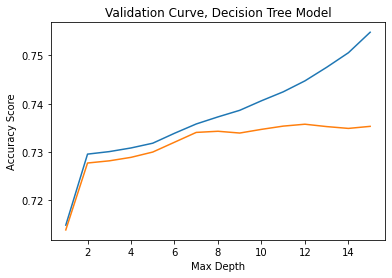

In [21]:
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curve, Decision Tree Model");

Divergent at `max_depth` 2 to 4. Let's go with 4

In [27]:
final_model_dt = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=12 ,random_state=42)
    )
final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O'...
                                          'mapping': Not attached       1
Attached-1 side    2
Attached-2 side    3
Attached-3 side    4
NaN               -2
dtype: int64},
                                         {'col': 'plan_configuration',
                                          'data_type': dtype('O'),
                                          'mapping': Rectangular                         1
L-shape                             2
Square                              3
Multi-projected                     4
Others                              5
T-shape                             6
U-shape                             7
E-shape                             8
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=12, random_state=42))])

In [28]:
# Test the model
lr_acc= model_lr.score(X_test,y_test)
dt_acc= final_model_dt.score(X_test,y_test)
print("Logicstics Regression Accuracy Scores:", lr_acc)
print("Decision Tree Accuracy Scores:", dt_acc)

Logicstics Regression Accuracy Scores: 0.7307094259901981
Decision Tree Accuracy Scores: 0.7360040414908903


# Communicating Results

Since both model perform quite well. We can stick to LR model for simplicity

In [24]:
features = model_lr.named_steps["onehotencoder"].get_feature_names()
importances = model_lr.named_steps["logisticregression"].coef_[0]
feat_imp = pd.Series(np.exp(importances), index=features).sort_values()
feat_imp.head()

has_superstructure_cement_mortar_brick    0.328695
roof_type_RCC/RB/RBC                      0.443578
foundation_type_RC                        0.465793
ground_floor_type_RC                      0.489905
foundation_type_Bamboo/Timber             0.508504
dtype: float64

These are most importance features

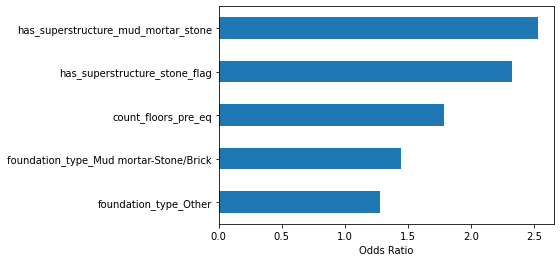

In [29]:
feat_imp.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

# Conclusion

Our model is successful predict the building damage condition with 73% accuracy.